In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from textblob import TextBlob
import torch
from transformers import BertModel, BertTokenizer, RobertaTokenizer, RobertaModel
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Reading the Data
train_raw_data = pd.read_excel("data/bank_a_sentiment_analysis_translated_inputdata.xlsx", engine = 'openpyxl')
validation_raw_data = pd.read_excel("data/bank_a_sentiment_analysis_translated_inputdata_unseen.xlsx", engine = 'openpyxl')

In [4]:
train_raw_data.head()

,review_id,translated_review,actual_sentiment
0,1.0,"in the branch of san marco evangelista, the em...",Positive
1,2.0,5 00 of commissions to withdraw your money at ...,Negative
2,3.0,when the f24 on the app thanks,Neutral
3,4.0,lower the commissions,Neutral
4,5.0,promotes and supports the small business in th...,Positive


In [5]:
validation_raw_data.head()

,review_id,translated_review,actual_sentiment
0,41.0,c always a little to fix,Neutral
1,44.0,there are multiple areas of improvement exampl...,Neutral
2,76.0,banca xxyyzz of valdengo to a great director,Positive
3,111.0,banca xxyyzz of valdengo to a great director,Negative
4,131.0,i lowered the votes given in previous evaluati...,Negative


In [6]:
print("Training Data shape",train_raw_data.shape)
print("Validation Data shape",validation_raw_data.shape)

Training Data shape (3486, 3)
Validation Data shape (200, 3)


In [7]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          3486 non-null   float64
 1   translated_review  3481 non-null   object 
 2   actual_sentiment   3482 non-null   object 
dtypes: float64(1), object(2)
memory usage: 81.8+ KB


In [8]:
validation_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          200 non-null    float64
 1   translated_review  200 non-null    object 
 2   actual_sentiment   200 non-null    object 
dtypes: float64(1), object(2)
memory usage: 4.8+ KB


In [9]:
# Check for Blank Records
train_raw_data[['translated_review','actual_sentiment']] = train_raw_data[['translated_review','actual_sentiment']].replace(r'^\s*$', np.nan, regex=True)
validation_raw_data[['translated_review','actual_sentiment']] = validation_raw_data[['translated_review','actual_sentiment']].replace(r'^\s*$', np.nan, regex=True)

In [10]:
train_raw_data.isna().sum(), validation_raw_data.isna().sum()

(review_id            0
 translated_review    5
 actual_sentiment     4
 dtype: int64,
 review_id            0
 translated_review    0
 actual_sentiment     0
 dtype: int64)

In [11]:
# Drop missing values and unique records
train_raw_data = train_raw_data.dropna(how = 'any')
print(train_raw_data.shape, train_raw_data.review_id.nunique())
print(validation_raw_data.shape, validation_raw_data.review_id.nunique())

(3477, 3) 3477
(200, 3) 200


# EDA

In [12]:
train_raw_data.describe(include = ['object'])

,translated_review,actual_sentiment
count,3477,3477
unique,3305,3
top,because i am fine,Positive
freq,11,1831


In [13]:
# Sentiment Distribution across Reviews
train_raw_data.actual_sentiment.value_counts()

Positive    1831
Neutral     1046
Negative     600
Name: actual_sentiment, dtype: int64

<AxesSubplot:xlabel='actual_sentiment', ylabel='count'>

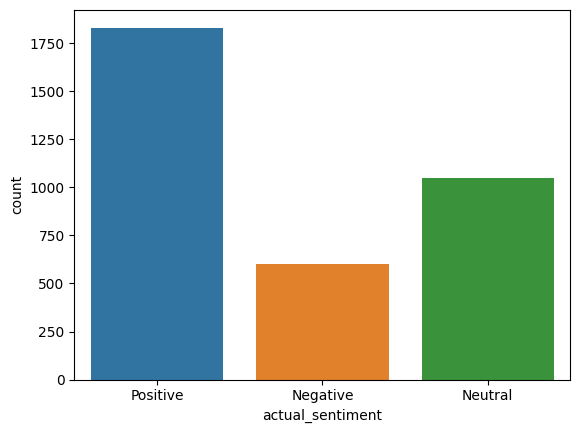

In [87]:
sns.countplot(data=train_raw_data, x="actual_sentiment")

# Sentiment vs Word Count Before Processing

In [14]:
# hypothesis - generally negative reviews does have higher word count
# Average Word Count across different types of Sentiment
def get_word_count(x):
    return len(x.split(" "))
train_raw_data['Word Count'] = train_raw_data['translated_review'].map(get_word_count)

In [88]:
train_raw_data.groupby('actual_sentiment').agg({'Word Count':['mean','median']}).reset_index()

actual_sentiment Word Count       
                         mean median
0         Negative  18.440000   10.0
1          Neutral   9.821224    6.0
2         Positive   8.648826    6.0

<AxesSubplot:xlabel='Word Count', ylabel='Density'>

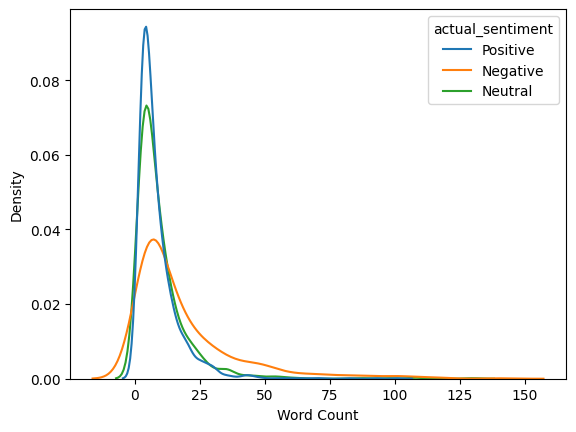

In [16]:
import scipy
sns.kdeplot(data = train_raw_data, x = 'Word Count', hue = 'actual_sentiment',
           common_norm=False)

In [17]:
train_raw_data.head()

,review_id,translated_review,actual_sentiment,Word Count
0,1.0,"in the branch of san marco evangelista, the em...",Positive,28
1,2.0,5 00 of commissions to withdraw your money at ...,Negative,13
2,3.0,when the f24 on the app thanks,Neutral,7
3,4.0,lower the commissions,Neutral,3
4,5.0,promotes and supports the small business in th...,Positive,9


# Cleaning and Processing

In [18]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [19]:
# StopWords Removal
def remove_stopwords(text):
    # Remove stopwords
    text = " ".join([word for word in text.split(" ") if word.lower() not in nlp.Defaults.stop_words])
    return text

# Text Lemmatization
def lemmatize_text(text):
    doc1 = nlp(text)
    return ' '.join([token.lemma_ for token in doc1])

#keeping only alphanumeric values
train_data = train_raw_data.copy(deep = True)
train_data['translated_review_processed'] = train_data['translated_review'].map(
                                                            lambda x: re.sub('[^a-zA-Z0-9 ]+','',x))
train_data['translated_review_processed'] = train_data['translated_review_processed'].map(remove_stopwords)
train_data['translated_review_processed'] = train_data['translated_review_processed'].map(lemmatize_text)

In [20]:
train_data.head()

,review_id,translated_review,actual_sentiment,Word Count,translated_review_processed
0,1.0,"in the branch of san marco evangelista, the em...",Positive,28,branch san marco evangelista employee include ...
1,2.0,5 00 of commissions to withdraw your money at ...,Negative,13,5 00 commission withdraw money counter theft
2,3.0,when the f24 on the app thanks,Neutral,7,f24 app thank
3,4.0,lower the commissions,Neutral,3,low commission
4,5.0,promotes and supports the small business in th...,Positive,9,promote support small business territory


# Check for Blank Reviews After processing the Data

In [21]:
train_data['translated_review_processed'] = train_data['translated_review_processed'].replace(r'^\s*$', np.nan, regex=True)
blank_reviews = train_data[train_data["translated_review_processed"].isna()]

In [22]:
print("Blank Review Count after processing {}".format(blank_reviews.shape[0]))
blank_reviews['actual_sentiment'].value_counts()

Blank Review Count after processing 22


Positive    13
Neutral      7
Negative     2
Name: actual_sentiment, dtype: int64

In [23]:
# Remove Blank Reviews
train_data.dropna(subset=["translated_review_processed"], inplace=True)

In [24]:
train_data.describe(include = ['object'])

,translated_review,actual_sentiment,translated_review_processed
count,3455,3455,3455
unique,3287,3,3065
top,because i am fine,Positive,find
freq,11,1818,19


In [25]:
# Analyse duplicates reviews
duplicated = train_data[train_data.duplicated(subset = ['translated_review_processed'], keep = False)]
same_review_diff_sentiment = duplicated.groupby('translated_review_processed').agg({'actual_sentiment':'nunique',
                                                                                   'review_id':'nunique'}).reset_index()
same_review_diff_sentiment = same_review_diff_sentiment[same_review_diff_sentiment['actual_sentiment'] > 1]
same_review_diff_sentiment.shape

(101, 3)

In [26]:
duplicated[duplicated['translated_review_processed'].isin(same_review_diff_sentiment['translated_review_processed'])].sort_values(
    by = ['translated_review_processed']).head(10)

,review_id,translated_review,actual_sentiment,Word Count,translated_review_processed
755,801.0,because i'm satisfied with it,Neutral,5,I m satisfied
246,257.0,i'm not satisfied,Negative,3,I m satisfied
2112,2241.0,i'm very satisfied,Positive,3,I m satisfied
2354,2491.0,i'm very satisfied,Positive,3,I m satisfied
2043,2168.0,i'm not satisfied,Negative,3,I m satisfied
401,420.0,i've always had a great time,Neutral,6,I ve great time
1652,1755.0,i've always had a great time,Positive,6,I ve great time
1137,1208.0,attention to the customer,Positive,4,attention customer
3430,3629.0,attention to the customer,Neutral,4,attention customer
1223,1299.0,attention to the customer,Neutral,4,attention customer


In [27]:
# Remove Records where same processed review have multiple sentiment.
train_data = train_data[~train_data['translated_review_processed'].isin(same_review_diff_sentiment['translated_review_processed'])]

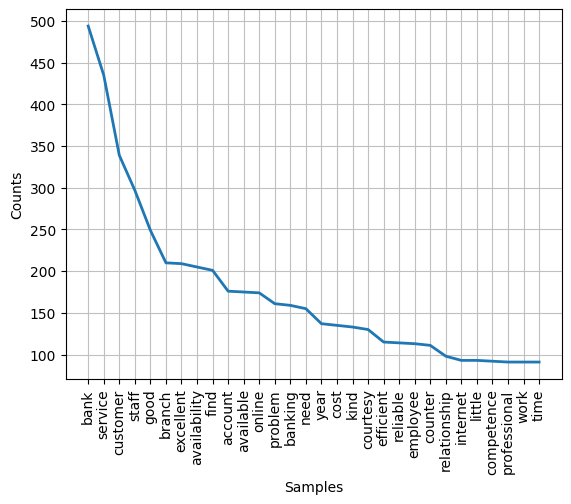

In [28]:
all_keywords = ' '.join(train_data['translated_review_processed']).split()
keyword_freq = nltk.FreqDist(all_keywords)
keyword_freq.plot(30)

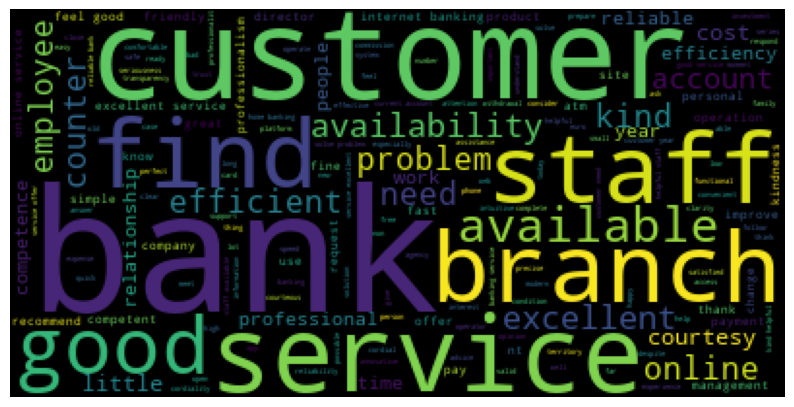

In [29]:
cloud = WordCloud()
cloud = cloud.generate(' '.join(train_data['translated_review_processed']))
plt.figure(figsize=(10,15))
plt.imshow(cloud)
plt.axis('off');

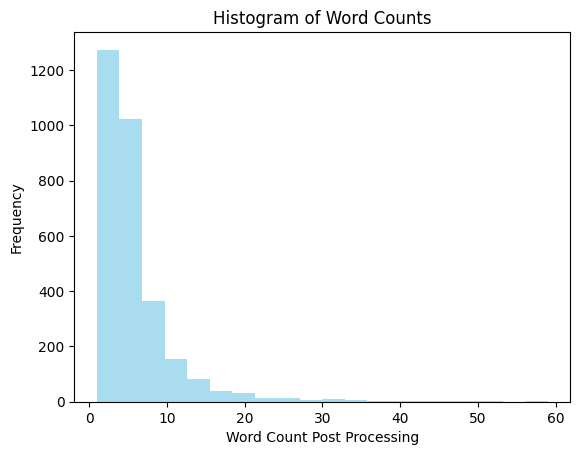

In [30]:
def analyze_word_counts(df):
    df['word_count_post_processing'] = df['translated_review_processed'].apply(lambda x: len(x.split()))
    plt.hist(df['word_count_post_processing'], bins=20, color='skyblue', alpha=0.7)
    plt.xlabel('Word Count Post Processing')
    plt.ylabel('Frequency')
    plt.title('Histogram of Word Counts')
    plt.show()
analyze_word_counts(train_data)

# Word Count Post and Pre-Processing Comparison

In [31]:
train_data['Word_Count_Difference'] = train_data['Word Count'] - train_data['word_count_post_processing']
# Check that Post Processing word Count will be >= 0
print("Reviews where the Post Processing Word Count has increased",train_data[train_data['Word_Count_Difference']<0].shape)

Reviews where the Post Processing Word Count has increased (1, 7)


In [32]:
train_data[train_data['Word_Count_Difference']<0]

,review_id,translated_review,actual_sentiment,Word Count,translated_review_processed,word_count_post_processing,Word_Count_Difference
3105,3279.0,i'm fine,Positive,2,I m fine,3,-1


In [33]:
print("Number of Review where words have been removed as part of the data processing is {} out of {}".\
      format(train_data[train_data['Word_Count_Difference']>0].shape[0], train_data.shape[0]))

Number of Review where words have been removed as part of the data processing is 2709 out of 3035


# Sentiment vs Word Count Post Processing

In [34]:
train_data.groupby('actual_sentiment').agg({'word_count_post_processing':['mean','median']}).reset_index().round(2)

actual_sentiment word_count_post_processing       
                                         mean median
0         Negative                       8.50    5.0
1          Neutral                       5.34    4.0
2         Positive                       4.68    4.0

<AxesSubplot:xlabel='word_count_post_processing', ylabel='Density'>

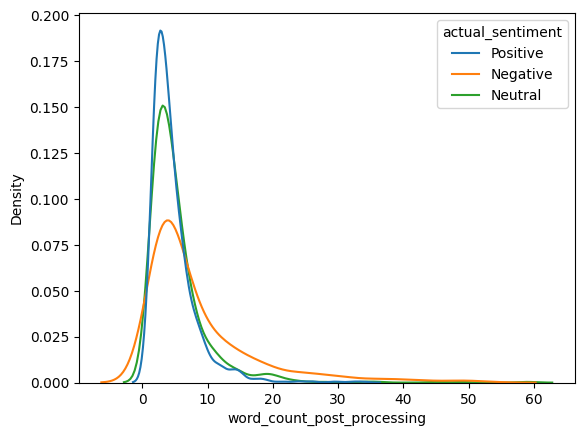

In [35]:
import scipy
sns.kdeplot(data = train_data, x = 'word_count_post_processing', hue = 'actual_sentiment',
           common_norm=False)

In [69]:
def get_tfidf_top_features(vectorizer, vectors,n_top=10):
    importance = np.argsort(np.asarray(vectors.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(vectorizer.get_feature_names())
    return tfidf_feature_names[importance[:n_top]]

def text_to_vectors(text):
    vectorizer = TfidfVectorizer(use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english',max_features=5000)
    vectors = vectorizer.fit_transform(text)
    top_10_features = get_tfidf_top_features(vectorizer, vectors,n_top=10)
    print(top_10_features)
    return vectors.toarray(), vectorizer
X_tf_idf, tf_idf_model = text_to_vectors(train_data['translated_review_processed'])

['bank' 'service' 'staff' 'customer' 'availability' 'good' 'excellent'
 'available' 'branch' 'online']


C:\Users\akash.gautam\.conda\envs\nlp_course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.61      0.53      0.57       114
     Neutral       0.37      0.17      0.23       175
    Positive       0.61      0.83      0.71       318

    accuracy                           0.58       607
   macro avg       0.53      0.51      0.50       607
weighted avg       0.54      0.58      0.54       607



In [72]:
print(metrics.accuracy_score(y_test, y_pred))

0.5831960461285008


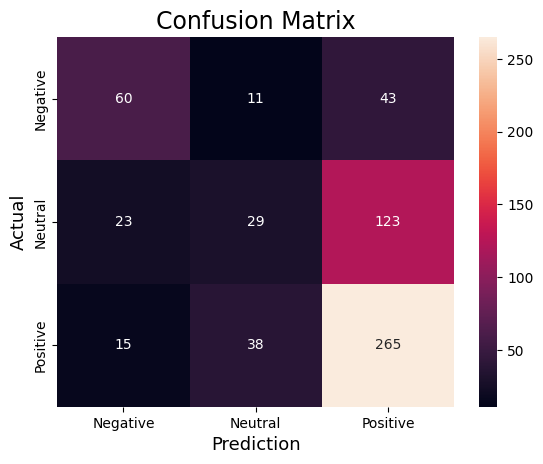

In [73]:
#compute the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [47]:
#word2vec vectorization
from gensim.models import Word2Vec

# Tokenize the reviews
sentences = train_data['translated_review_processed'].apply(lambda x: x.split()).tolist()

# Train a Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save("word2vec.model")

# Convert reviews to vectors
def review_to_vec(review, model):
    tokens = review.split()
    vec = np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0)
    return vec

train_data['w2v_vector'] = train_data['translated_review_processed'].apply(lambda x: review_to_vec(x, w2v_model))

In [60]:
# For Word2Vec
X_w2v = np.array(train_data['w2v_vector'].tolist())
y = train_data['actual_sentiment']
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)

In [62]:
model = RandomForestClassifier()
model.fit(X_train_w2v, y_train_w2v)
y_pred = model.predict(X_test_w2v)
print(classification_report(y_test_w2v, y_pred))

              precision    recall  f1-score   support

    Negative       0.59      0.17      0.26       114
     Neutral       0.41      0.17      0.24       175
    Positive       0.58      0.91      0.71       318

    accuracy                           0.56       607
   macro avg       0.53      0.41      0.40       607
weighted avg       0.53      0.56      0.49       607



In [75]:
def textblob_sentiment_scores(sentence):
 
    sentiment = TextBlob(sentence).polarity
    
    # decide sentiment as positive, negative and neutral
    if sentiment >= 0.05 :
        label = "Positive"
 
    elif sentiment <= - 0.05 :
        label = "Negative"
 
    else :
        label = "Neutral"
    
    return label

In [76]:
train_data['y_pred_textblob'] = train_data['translated_review_processed'].apply(textblob_sentiment_scores)
print(metrics.accuracy_score(train_data['actual_sentiment'], train_data['y_pred_textblob']))
metrics.confusion_matrix(train_data['actual_sentiment'], train_data['y_pred_textblob'])

0.46985172981878087


array([[144, 245, 183],
       [ 57, 394, 423],
       [ 28, 673, 888]], dtype=int64)

In [77]:
print(classification_report(train_data['actual_sentiment'], train_data['y_pred_textblob']))

              precision    recall  f1-score   support

    Negative       0.63      0.25      0.36       572
     Neutral       0.30      0.45      0.36       874
    Positive       0.59      0.56      0.58      1589

    accuracy                           0.47      3035
   macro avg       0.51      0.42      0.43      3035
weighted avg       0.52      0.47      0.47      3035



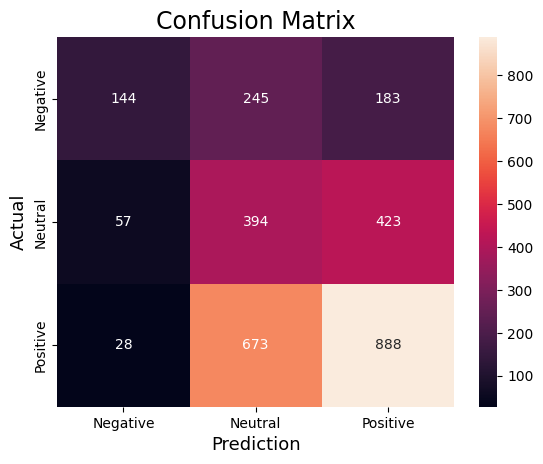

In [78]:
#compute the confusion matrix.
cm = confusion_matrix(train_data['actual_sentiment'], train_data['y_pred_textblob'])
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [79]:
train_raw_data['y_pred_textblob'] = train_raw_data['translated_review'].apply(textblob_sentiment_scores)
print(metrics.accuracy_score(train_raw_data['actual_sentiment'], train_raw_data['y_pred_textblob']))
metrics.confusion_matrix(train_raw_data['actual_sentiment'], train_raw_data['y_pred_textblob'])
print(classification_report(train_raw_data['actual_sentiment'], train_raw_data['y_pred_textblob']))

0.4800115041702617
              precision    recall  f1-score   support

    Negative       0.45      0.26      0.33       600
     Neutral       0.32      0.39      0.35      1046
    Positive       0.60      0.60      0.60      1831

    accuracy                           0.48      3477
   macro avg       0.46      0.42      0.43      3477
weighted avg       0.49      0.48      0.48      3477



In [80]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def vader_sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        label = "Positive"
 
    elif sentiment_dict['compound'] <= - 0.05 :
        label = "Negative"
 
    else :
        label = "Neutral"
    
    return label

In [83]:
train_data['y_pred_vader'] = train_data['translated_review_processed'].apply(vader_sentiment_scores)
print(metrics.accuracy_score(train_data['actual_sentiment'], train_data['y_pred_vader']))
metrics.confusion_matrix(train_data['actual_sentiment'], train_data['y_pred_vader'])

0.5014827018121911


array([[ 136,  200,  236],
       [  67,  312,  495],
       [  75,  440, 1074]], dtype=int64)

In [84]:
print(classification_report(train_data['actual_sentiment'], train_data['y_pred_vader']))

              precision    recall  f1-score   support

    Negative       0.49      0.24      0.32       572
     Neutral       0.33      0.36      0.34       874
    Positive       0.60      0.68      0.63      1589

    accuracy                           0.50      3035
   macro avg       0.47      0.42      0.43      3035
weighted avg       0.50      0.50      0.49      3035



In [86]:
train_raw_data['y_pred_vader'] = train_raw_data['translated_review'].apply(vader_sentiment_scores)
print(metrics.accuracy_score(train_raw_data['actual_sentiment'], train_raw_data['y_pred_vader']))
metrics.confusion_matrix(train_raw_data['actual_sentiment'], train_raw_data['y_pred_vader'])
print(classification_report(train_raw_data['actual_sentiment'], train_raw_data['y_pred_vader']))

0.5165372447512223
              precision    recall  f1-score   support

    Negative       0.48      0.32      0.39       600
     Neutral       0.33      0.31      0.32      1046
    Positive       0.61      0.70      0.65      1831

    accuracy                           0.52      3477
   macro avg       0.48      0.44      0.45      3477
weighted avg       0.50      0.52      0.51      3477



In [ ]:
# Train on Unprocessed natural data
X_original, top10_feaures = text_to_vectors(train_data['translated_review'])
y_original = train_data['actual_sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
X_train['y_pred_vader_original'] = X_train['translated_review'].apply(vader_sentiment_scores)
print(metrics.accuracy_score(X_train['actual_sentiment'], X_train['y_pred_vader_original']))
metrics.confusion_matrix(X_train['actual_sentiment'], X_train['y_pred_vader_original'])

In [ ]:
print(classification_report(train_data['actual_sentiment'], train_data['y_pred_vader_original']))

In [ ]:
import transformers

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [ ]:
def build_bert_sentiment_model(data,model):
    # Tokenize the review texts and convert them to input tensors
    tokenized_texts = [tokenizer.tokenize(review) for review in data['translated_review']]
    input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
    input_tensors = [torch.tensor(ids).unsqueeze(0) for ids in input_ids]
    
    # Enable GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Perform sentiment analysis on each review
    sentiments = []
    model.eval()
    with torch.no_grad():
        for inputs in input_tensors:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Extract the pooled output representation
            pooled_output = outputs[1]
            
            if pooled_output[0][0] >= 0.5:
                sentiment = 'Positive' 
            elif pooled_output[0][0] <= -0.5:
                sentiment = 'Negative'
            else:
                sentiment = 'Neutral'
            sentiments.append(sentiment)

    
    return sentiments

In [ ]:
train_data['y_pred_BertSentiment'] = build_bert_sentiment_model(train_data,model)
print(metrics.accuracy_score(train_data['actual_sentiment'], train_data['y_pred_BertSentiment']))
metrics.confusion_matrix(train_data['actual_sentiment'], train_data['y_pred_BertSentiment'])

In [ ]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in train_data.translated_review.unique():
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

# Load pre-trained BERT model and tokenizer
model_name = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
reviews = train_raw_data["translated_review"].values
# using pipeline
from transformers import pipeline
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
predicted_output = sentiment_task(list(reviews))

In [ ]:
train_raw_data['roberta_base_sentiment_output'] = [x['label'].capitalize() for x in predicted_output]
print(metrics.accuracy_score(train_raw_data['actual_sentiment'], train_raw_data['roberta_base_sentiment_output']))
metrics.confusion_matrix(train_raw_data['actual_sentiment'], train_raw_data['roberta_base_sentiment_output'])

In [ ]:
#compute the confusion matrix.
cm = confusion_matrix(train_data['actual_sentiment'], train_data['y_pred_textblob'])
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# Validation Sample Output

In [68]:
# Process the Validation Data as well
def processing_validation_data(data = None):
    """
        This function takes in the raw dataset and apply the preprocessing steps
        to generate tokens from text.
    
    """
    #keeping only alphanumeric values
    data['translated_review_processed'] = data['translated_review'].map(
                                                                lambda x: re.sub('[^a-zA-Z0-9 ]+','',x))
    data['translated_review_processed'] = data['translated_review_processed'].map(remove_stopwords)
    data['translated_review_processed'] = data['translated_review_processed'].map(lemmatize_text)
    data['translated_review_processed'] = data['translated_review_processed'].replace(r'^\s*$', np.nan, regex=True)

    # Remove Blank Reviews
    data.dropna(subset=["translated_review_processed"], inplace=True)

    # Analyse duplicates reviews
    duplicated = data[data.duplicated(subset = ['translated_review_processed'], keep = False)]
    same_review_diff_sentiment = duplicated.groupby('translated_review_processed').agg({'actual_sentiment':'nunique',
                                                                                       'review_id':'nunique'}).reset_index()
    same_review_diff_sentiment = same_review_diff_sentiment[same_review_diff_sentiment['actual_sentiment'] > 1]
    print("Number of Duplicates Record",same_review_diff_sentiment.shape[0])
    if same_review_diff_sentiment.shape[0] > 0:
        data = data[~data['translated_review_processed'].isin(
        same_review_diff_sentiment['translated_review_processed'])]
    return data

validation_data = processing_validation_data(data = validation_raw_data)


Number of Duplicates Record 2


In [ ]:
model = RandomForestClassifier()
model.fit(X_train_w2v, y_train_w2v)
y_pred = model.predict(X_test_w2v)
print(classification_report(y_test_w2v, y_pred))

In [ ]:
validation_data['y_pred_textblob'] = validation_data['translated_review_processed'].apply(textblob_sentiment_scores)
print(metrics.accuracy_score(validation_data['actual_sentiment'], validation_data['y_pred_textblob']))
metrics.confusion_matrix(validation_data['actual_sentiment'], validation_data['y_pred_textblob'])

In [ ]:
validation_reviews = validation_raw_data["translated_review"].values
# using pipeline
from transformers import pipeline
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
predicted_output_val = sentiment_task(list(validation_reviews))

In [ ]:
validation_raw_data['roberta_base_sentiment_output'] = [x['label'].capitalize() for x in predicted_output_val]
print(metrics.accuracy_score(validation_raw_data['actual_sentiment'], validation_raw_data['roberta_base_sentiment_output']))
metrics.confusion_matrix(validation_raw_data['actual_sentiment'], validation_raw_data['roberta_base_sentiment_output'])

In [ ]:
#compute the confusion matrix.
cm = confusion_matrix(validation_raw_data['actual_sentiment'], validation_raw_data['roberta_base_sentiment_output'])
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=["Negative","Neutral", "Positive"],
            yticklabels=["Negative","Neutral", "Positive"]
            )
plt.ylabel("Actual", fontsize=13)
plt.xlabel("Prediction", fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()